# Problem Description

The purpose of this project is to correctly segment consumer complaints gathered by the Consumer Financial Protection Bureau into 5 categories:
- Credit Card
- Credit Reporting
- Debt Collection
- Mortgages and Loans (includes car loans, payday loans, student loans, etc.)
- Retail Banking (includes checking/savings accounts, as well as money transfers, Venmo, etc.)

I will use Natural Language Processing in order to automate this task.

I will first try to perform this segmentation with a Random Forest model.  I will then try to perform this operation with a Deep Learning model.

I got this dataset from this kaggle site: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp.  This dataset is for the time period March 2020 to March 2021.

# Exploratory Data Analysis

In [1]:
# Import data analysis libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import tensorflow libraries
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
#from tf.test.gpu_device_name()

# Import sklearn libraries
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Import NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

# Import additional libraries
import sys, os, csv, codecs
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)



In [2]:
# first look at the data
df = pd.read_csv('../input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Remove the 'Unnamed: 0' column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [4]:
# Look at the size of the data
df.shape

(162421, 2)

In [5]:
# Look at the data types
df.dtypes

product      object
narrative    object
dtype: object

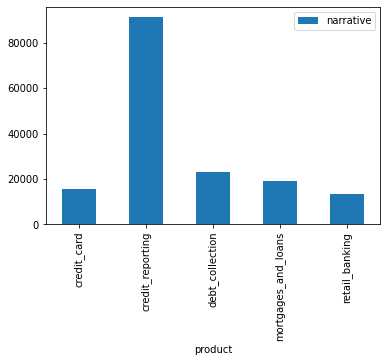

In [6]:
# Look at counts of complaints across categories
df.groupby('product').count().plot(kind='bar')
plt.show()

Because the categories are not balanced, I will make my model evaluation using F1-score instead of accuracy.

In [7]:
# Check for null values
df.isnull().sum()

product       0
narrative    10
dtype: int64

In [8]:
# Remove nulls and then check again for nulls
df = df.dropna(subset=['narrative'])
df.isnull().sum()

product      0
narrative    0
dtype: int64

# Analysis (model building) using RandomForest

In [11]:
df_for_rf_model = df.copy()

In [12]:
#Create a function to clean the text for each complaint
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):

    clean_words = []
    
    word_list = text.split()
    for word in word_list:
        word_l = word.lower().strip() # convert to lower case text and remove white space
        if word_l.isalpha():
            if len(word_l) > 3: # Drop words with less than 3 character
                if word_l not in stopwords : # don't include stopwords
                    clean_words.append(word_l)
                else:
                    continue
    return clean_words       

In [13]:
# TF-IDF is a measure of originality of a word by comparing the number of times a word appears in a doc with the number of docs
# the word appears in
tfidf = TfidfVectorizer(analyzer=clean_text)
x_tfidf = tfidf.fit_transform(df_for_rf_model['narrative'])

In [14]:
# Look at the dimensions of the matrix
x_tfidf.shape

(162411, 43275)

In [16]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, df_for_rf_model['product'], test_size=0.2, random_state=42)

In [17]:
#Using RandomForest Classifier because they are helpful when dealing with the high dimensional noisy data in text classification
rfc = RandomForestClassifier(n_jobs=-1) # -1 means using all processors
rfc_model = rfc.fit(X_train,y_train)

In [18]:
# Generate predictions
predictions = rfc_model.predict(X_test)

In [19]:
# Look at the confusion matrix and classification report after building and using the RandomForest model
print("Confusion Matrix:\n\n",confusion_matrix(y_test,predictions))
print("\n")
print("Classification Report:\n\n",classification_report(y_test,predictions))

Confusion Matrix:

 [[ 2128   583    42   107   272]
 [  100 17846   192   124    21]
 [   88  1209  3125   155    38]
 [   74   529    98  2992    77]
 [  196   153    18    67  2249]]


Classification Report:

                      precision    recall  f1-score   support

        credit_card       0.82      0.68      0.74      3132
   credit_reporting       0.88      0.98      0.92     18283
    debt_collection       0.90      0.68      0.77      4615
mortgages_and_loans       0.87      0.79      0.83      3770
     retail_banking       0.85      0.84      0.84      2683

           accuracy                           0.87     32483
          macro avg       0.86      0.79      0.82     32483
       weighted avg       0.87      0.87      0.87     32483



The weighted average f1-score for this model is 0.87.  Let's see if I can improve this score using a deep learning model.